#### Karger's Algorithm w/ Adjacency List 

```
def karger(G):
    n <- |V|
    while n >2:
        select a random edge (u,v)
        perform contraction of (u,v)
        n <- n-1
```

Given a graph $G$, contraction of edge $(u,v)$ merges vertices $u$ and $v$ into a single super-vertex $\{u,v\}$ and removes any self-loops.

To implement the contraction operation such that it runs in $O(n)$ time, where $n$ is the number of vertices is the graph, we will maintain two data structures:

1) An array containing all the vertices, each $u$ vertex internally maintains a linked list of tuples, each tuple contains a pointers to an adjacent vertex $v$ and a pointer to the corresponding edge $(u,v)$. So, this data structure is basically an `adjacency list` representration of the graph.

2) A dynamic array containing all edges in the graph, called the `edge list`. Each edge $(u,v)$ internally contains pointers to the vertices $u$ and $v$ and also the array index position where it is located. Edges from this array can be accessed/modified and removed in $O(1)$ time (to remove an edge, we simply swap it with the last element of the array and decrease the array size by 1).

Given a randomly selected edge $(u,v)$  from the edge list, we perform a contraction of this edge as follows. First, we merge vertices $u$ and $v$. We do this by taking the adjacency list of $v$ and appending it to the adjacency list of $u$. Thus $u$ represents the new merged super-vertex and $v$ is "discarded". We make sure to remove all self-loops by deleting all the parallel edges between $(u,v)$. We also want to find all vertices $w$ that were previously adjacent to $v$ and replace $v$ inside adjacency list of $w$ with the super-vertex $u$, and at the same time, we also update the edges $(v,w)$ to $(u,w)$ 


```
def contraction(edge):
    (u,v) <- edge
    
    # self-loop removal
    for each w in u.adjacency list:
        if w == v:
            remove w from u.adjacency_list
            remove the edge (u,w) from edge list  
    
    for each w in v.adjacency_list:
        if w != u:
            append w to u.adjacency_list 
            replace v in w.adjacency_list with u
            update edge (v,w) to (u,w) inside edge list 



```



In [82]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(E, fig_size=5):
    # Create a new graph
    G = nx.Graph()

    # Add edges to the graph
    for (u, v) in E:
        G.add_edge(u, v)

    # Draw the graph
    plt.figure(figsize=(fig_size, fig_size))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

In [98]:
import random
random.seed(0)

class Vertex:
    def __init__(self, id):
        self.id = id
        self.adjacency_list = []

    def __str__(self):
        return str(self.id)

    def __repr__(self):
        return str(self.id)


class Edge:
    def __init__(self, id, u, v, array_pos=None):
        self.id = id
        self.u = u
        self.v = v
        self.array_pos = array_pos

    def __str__(self):
        return str((self.u, self.v))

    def __repr__(self):
        return str((self.u, self.v))


def find_mincut(num_iters, G, verbose=False):
    min_cut_edges = None
    min_cut_size = float('inf')
    for i in range(num_iters):
        if verbose:
            print(f"\nKarger Iteration # {i+1}")
        cut_edges = karger(G, verbose=verbose)
        if len(cut_edges) < min_cut_size:
            min_cut_edges = cut_edges
            min_cut_size = len(cut_edges)
    return min_cut_edges


def karger(G, verbose=False):
    (V, E) = G  # V is a list of vertex ids (0,1,2,...,n-1) and E is a list of edges [(u,v), ...]

    # create array of vertices
    vertices = []
    for v in V:
        vertices.append(Vertex(v))

    # create edge list and adjacency list inside each vertex
    edge_list = []
    for i, (u,v) in enumerate(E):
        edge = Edge(i, u, v, array_pos=len(edge_list))
        edge_list.append(edge)
        vertices[u].adjacency_list.append((vertices[v],edge))
        vertices[v].adjacency_list.append((vertices[u],edge))    

    def print_vertices():
        print("\nVertices:\n")
        for v in vertices:
            if v is not None:
                print(f"{v.id}: {v.adjacency_list}")

    def print_edge_list():
        print("\nEdge list:\n")
        for e in edge_list:
            print(f"Position: {e.array_pos} --> ({e.u}, {e.v})")

    if verbose:
        print_vertices()
        print_edge_list()
    

    # perform n-2 edge contractions
    for i in range(len(V)-2):
        # draw an edge uniformly at random from the edge list
        edge = random.choice(edge_list)
        #print(f"\nRandom edge selected: {edge}")

        # perform edge contraction
        contraction(edge, vertices, edge_list, verbose)
        if verbose:
            print(f"Done contraction.")    
            print_vertices()
            print_edge_list()

    # output remaining edges after contractions (use edge id to get the original edge label)
    cut_edges = [E[e.id] for e in edge_list]
    if verbose:
        print(f"\nRemaining edges after contractions: {cut_edges}")
    
    return cut_edges


def contraction(edge, vertices, edge_list, verbose):
    u = vertices[edge.u]
    v = vertices[edge.v]
    if verbose:
        print(f"Contracting edge ({edge.u},{edge.v})")
        print(f"u adj list: {u.adjacency_list}")
        print(f"v adj list: {v.adjacency_list}")
    # remove all occurrences of v from the adjacency list of u and also remove parallel (u,v) edges from edge list (self-loop removal)
    u_list = u.adjacency_list.copy()
    u.adjacency_list = []
    for (w,edge) in u_list:
        if w.id == v.id:
            # remove (u,v) edge from edge list
            pos = edge.array_pos
            edge_list[pos] = edge_list[-1]
            edge_list[pos].array_pos = pos
            edge_list.pop()
            edge.array_pos = None
        else:
            u.adjacency_list.append((w,edge))

    # merge v into u
    for (w,edge) in v.adjacency_list:
        if w.id != u.id:
            u.adjacency_list.append((w,edge))
            # update the adjacency list of w: replace v with u and update edges (v,w) to (u,w)
            for i, (x,edge) in enumerate(w.adjacency_list):
                if x.id == v.id:
                    w.adjacency_list[i] = (u, edge)
                    # update the edge
                    if edge.u == v.id:
                        edge.u = u.id
                    else:
                        edge.v = u.id
                    
    vertices[v.id] = None


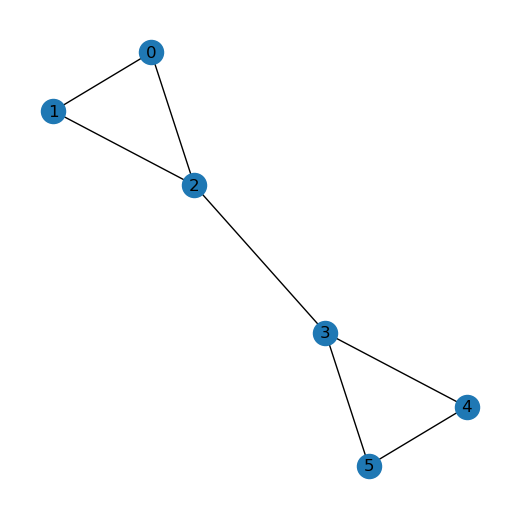

[(2, 3)]

In [99]:
# example graph
V = [0,1,2,3,4,5]
E = [(0,1), (0,2), (1,2), (2,3), (3,4), (3,5), (4,5)]
G = (V,E)

# plot the graph
plot_graph(E, fig_size=5)


# test karger
num_iters = 10
find_mincut(num_iters, G, verbose=False)




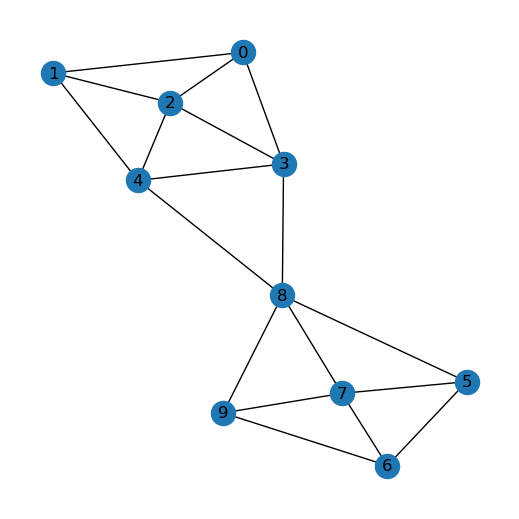

[(3, 8), (8, 4)]

In [100]:
# example graph
V = [0,1,2,3,4,5,6,7,8,9]
E = [(0,1),(1,2),(3,0),(4,1),(8,9),(0,2),(2,3),(8,4),(2,4),(4,3),(3,8),(8,5),(5,7),(8,7),(5,6),(6,7),(7,9),(9,6)]
G = (V,E)

# plot the graph
plot_graph(E, fig_size=5)


# test karger
num_iters = 20
find_mincut(num_iters, G, verbose=False)
